In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [60]:
download_url = 'https://mapfiles.nrel.gov/data/solar/d0ca611edd5f16e36b0aad9e8bbc23e5.zip'

response = requests.get(download_url)
zip_bytes = io.BytesIO(response.content)

with zipfile.ZipFile(zip_bytes, 'r') as zip_ref:
    print(zip_ref.namelist())
    csv_filename = zip_ref.namelist()[0]
    zip_ref.extract(csv_filename, '.')  

['d0ca611edd5f16e36b0aad9e8bbc23e5/1398305_1.93_125.50_2015.csv']


In [61]:
csv_filename = '1398305_1.93_125.50_2015.csv'

data = pd.read_csv(csv_filename, skiprows=2)
data.head()

,Year,Month,Day,Hour,Minute,Temperature,Alpha,Aerosol Optical Depth,Asymmetry,Clearsky DHI,...,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2015,1,1,0,30,28.1,0.72,0.0574,0.63,0,...,0,0,0.249,84.38,155.73,0,1020,4.5,17,4.0
1,2015,1,1,1,30,27.9,0.71,0.0557,0.63,0,...,0,0,0.249,85.78,146.15,0,1020,4.5,16,4.1
2,2015,1,1,2,30,27.8,0.71,0.0556,0.63,0,...,0,0,0.249,86.76,133.93,0,1020,4.6,17,4.1
3,2015,1,1,3,30,27.7,0.69,0.0563,0.63,0,...,0,0,0.249,87.79,120.70,0,1020,4.6,20,4.2
4,2015,1,1,4,30,27.7,0.67,0.0571,0.63,0,...,0,0,0.249,88.17,107.07,0,1020,4.6,24,4.3


In [62]:
data.sample(5)

,Year,Month,Day,Hour,Minute,Temperature,Alpha,Aerosol Optical Depth,Asymmetry,Clearsky DHI,...,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
6056,2015,9,10,8,30,27.3,0.79,0.1573,0.60,128,...,0,648,0.280,82.94,46.31,0,1022,4.3,176,5.3
5556,2015,8,20,12,30,27.2,0.63,0.1473,0.63,143,...,0,857,0.277,79.54,16.03,0,1018,3.8,181,7.4
5990,2015,9,7,14,30,27.8,0.76,0.1327,0.60,121,...,0,694,0.279,79.08,43.52,0,1018,4.0,183,7.2
7674,2015,11,16,18,30,28.3,0.72,0.0816,0.61,0,...,0,0,0.264,85.45,106.55,0,1018,5.7,52,4.4
3319,2015,5,19,7,30,28.7,0.64,0.0965,0.62,85,...,0,401,0.262,85.20,62.19,0,1020,6.0,161,3.3


In [63]:
data.shape

(8760, 26)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   8760 non-null   int64  
 1   Month                  8760 non-null   int64  
 2   Day                    8760 non-null   int64  
 3   Hour                   8760 non-null   int64  
 4   Minute                 8760 non-null   int64  
 5   Temperature            8760 non-null   float64
 6   Alpha                  8760 non-null   float64
 7   Aerosol Optical Depth  8760 non-null   float64
 8   Asymmetry              8760 non-null   float64
 9   Clearsky DHI           8760 non-null   int64  
 10  Clearsky DNI           8760 non-null   int64  
 11  Clearsky GHI           8760 non-null   int64  
 12  Cloud Type             8760 non-null   int64  
 13  Dew Point              8760 non-null   float64
 14  DHI                    8760 non-null   int64  
 15  DNI 

In [65]:
data.describe()

,Year,Month,Day,Hour,Minute,Temperature,Alpha,Aerosol Optical Depth,Asymmetry,Clearsky DHI,...,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
count,8760.0,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000
mean,2015.0,6.526027,15.720548,11.500000,30.0,28.029441,0.847992,0.142061,0.622493,51.230708,...,0.172260,241.758562,0.258386,83.361332,89.954672,0.0,1019.024201,5.116381,150.567123,4.301941
std,0.0,3.448048,8.796749,6.922582,0.0,0.607811,0.342735,0.125779,0.015336,61.049542,...,0.679907,331.721806,0.014531,3.491684,47.529935,0.0,1.569375,0.826108,102.603235,1.618637
min,2015.0,1.000000,1.000000,0.000000,30.0,26.100000,0.170000,0.029600,0.600000,0.000000,...,0.000000,0.000000,0.224000,71.340000,0.580000,0.0,1015.000000,2.600000,0.000000,0.200000
25%,2015.0,4.000000,8.000000,5.750000,30.0,27.600000,0.610000,0.080100,0.610000,0.000000,...,0.000000,0.000000,0.249000,80.830000,47.327500,0.0,1018.000000,4.500000,42.000000,3.100000
50%,2015.0,7.000000,16.000000,11.500000,30.0,28.000000,0.790000,0.105100,0.620000,0.000000,...,0.000000,0.000000,0.258000,83.530000,89.840000,0.0,1019.000000,5.200000,172.000000,4.300000
75%,2015.0,10.000000,23.000000,17.250000,30.0,28.500000,1.060000,0.147500,0.630000,101.000000,...,0.000000,484.250000,0.272000,85.920000,132.087500,0.0,1020.000000,5.800000,189.000000,5.500000
max,2015.0,12.000000,31.000000,23.000000,30.0,29.500000,1.830000,1.443400,0.650000,380.000000,...,5.000000,1053.000000,0.287000,93.070000,179.650000,0.0,1024.000000,6.800000,360.000000,9.400000


In [66]:
data.isnull().sum()

Year                     0
Month                    0
Day                      0
Hour                     0
Minute                   0
Temperature              0
Alpha                    0
Aerosol Optical Depth    0
Asymmetry                0
Clearsky DHI             0
Clearsky DNI             0
Clearsky GHI             0
Cloud Type               0
Dew Point                0
DHI                      0
DNI                      0
Fill Flag                0
GHI                      0
Ozone                    0
Relative Humidity        0
Solar Zenith Angle       0
Surface Albedo           0
Pressure                 0
Precipitable Water       0
Wind Direction           0
Wind Speed               0
dtype: int64

In [67]:
data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
8755    False
8756    False
8757    False
8758    False
8759    False
Length: 8760, dtype: bool

In [68]:
columns_to_drop = ['Fill Flag', 'Surface Albedo', 'Ozone', 'Alpha', 
                   'Aerosol Optical Depth', 'Asymmetry']
existing_cols_to_drop = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns=existing_cols_to_drop, errors='ignore')

print(f"Kolom yang dihapus: {existing_cols_to_drop}")

Kolom yang dihapus: ['Fill Flag', 'Surface Albedo', 'Ozone', 'Alpha', 'Aerosol Optical Depth', 'Asymmetry']


In [69]:
missing_summary = data.isnull().sum()
print(f"\nMissing values setelah cleaning:")
print(missing_summary[missing_summary > 0])



Missing values setelah cleaning:
Series([], dtype: int64)


In [70]:
data = data.fillna(method='ffill').fillna(method='bfill')

data['datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
data['hour'] = data['datetime'].dt.hour
data['day_of_year'] = data['datetime'].dt.dayofyear
data['month'] = data['datetime'].dt.month
data['season'] = data['month'].map({12: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 
                                   6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3})

data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 365)

In [71]:
PANEL_AREA = 1.65  # m2 per panel
ETA_REF = 0.2      # efisiensi referensi 20%
BETA = -0.004      # koefisien suhu per °C
T_REF = 25         # suhu referensi °C
U_LOSS = 20        # koefisien kehilangan panas W/m2K

data['G_eff'] = data['GHI'] * np.cos(np.radians(data['Solar Zenith Angle']))
data['G_eff'] = np.maximum(data['G_eff'], 0)

data['T_cell'] = data['Temperature'] + (data['GHI'] / 800) * 30
data['delta_T'] = data['T_cell'] - T_REF
data['efficiency'] = ETA_REF * (1 + BETA * data['delta_T'])
data['efficiency'] = np.clip(data['efficiency'], 0.05, 0.25)

data['P_theoretical'] = data['G_eff'] * PANEL_AREA * data['efficiency'] / 1000

wind_effect = 1 + 0.05 * (data['Wind Speed'] - 2) / 10
wind_effect = np.clip(wind_effect, 0.8, 1.2)
humidity_effect = 1 - 0.1 * (data['Relative Humidity'] - 60) / 100
humidity_effect = np.clip(humidity_effect, 0.7, 1.1)

data['P_out'] = data['P_theoretical'] * wind_effect * humidity_effect
data['P_out'] = np.maximum(data['P_out'], 0)

In [72]:
print(f"Formula yang digunakan:")
print(f"1. G_eff = GHI × cos(zenith_angle)")
print(f"2. T_cell = T_ambient + (GHI/800) × 30")
print(f"3. η = η_ref × (1 + β × ΔT)")
print(f"4. P_out = G_eff × Area × η × wind_effect × humidity_effect")

Formula yang digunakan:
1. G_eff = GHI × cos(zenith_angle)
2. T_cell = T_ambient + (GHI/800) × 30
3. η = η_ref × (1 + β × ΔT)
4. P_out = G_eff × Area × η × wind_effect × humidity_effect


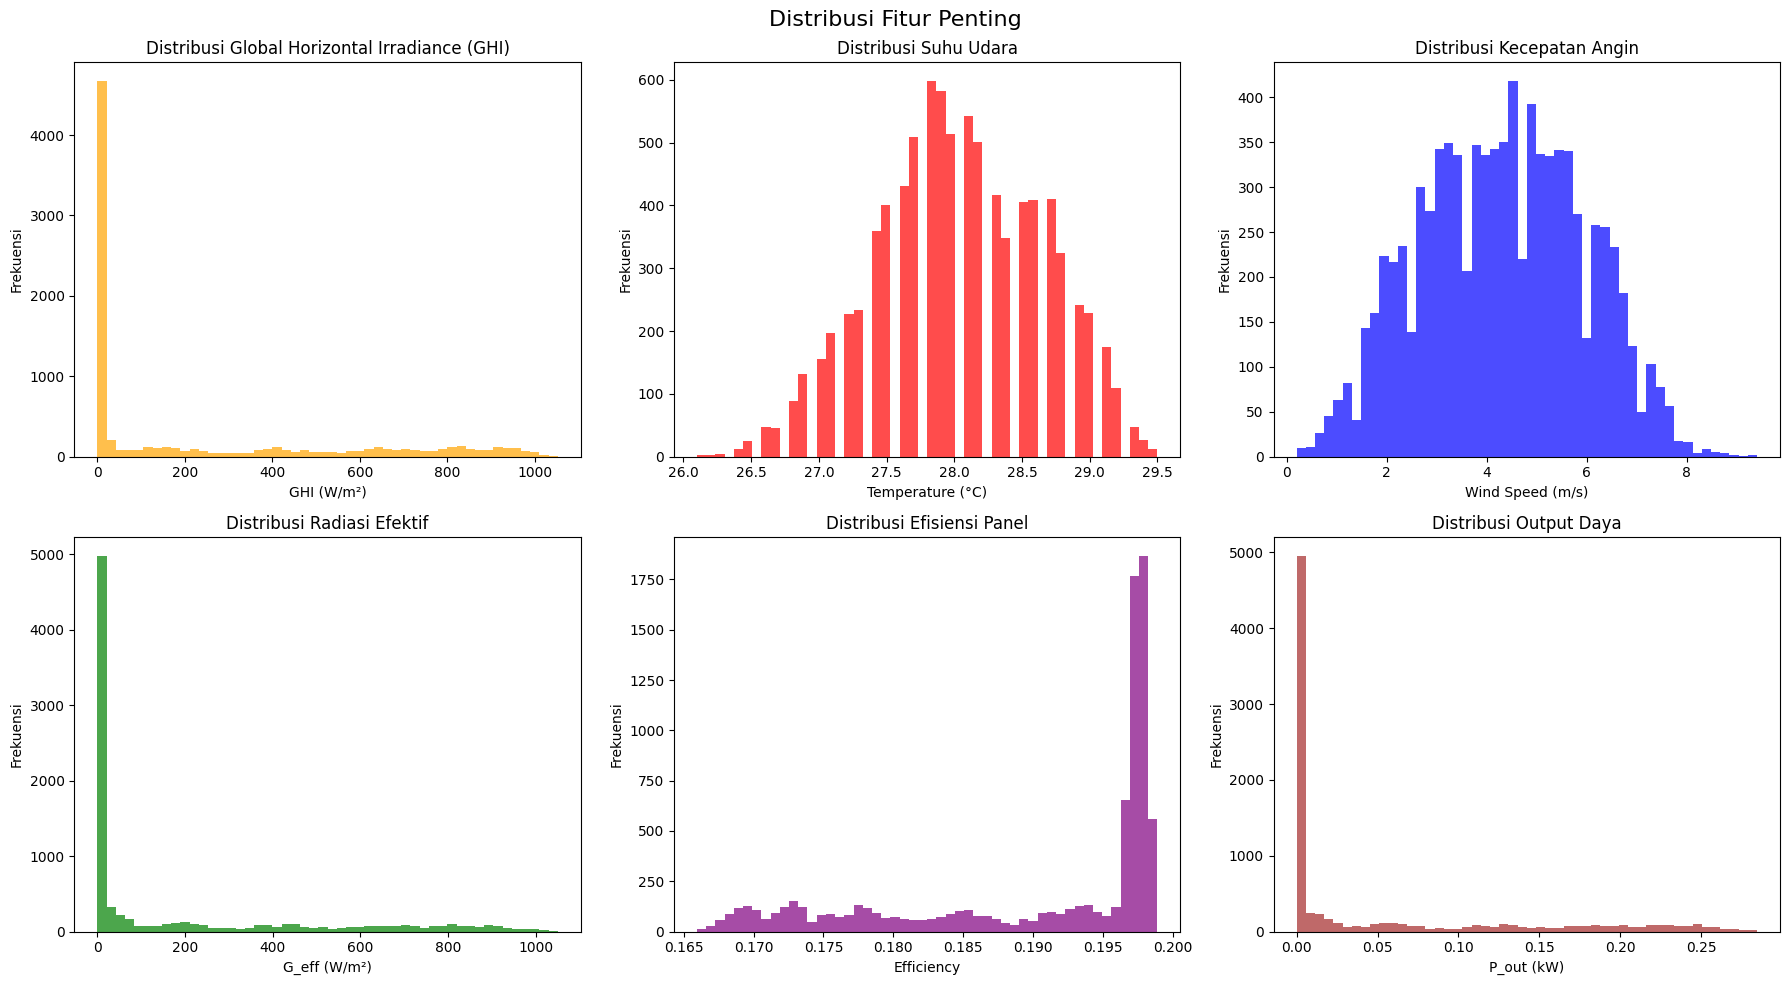

In [73]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribusi Fitur Penting', fontsize=16)

plt.subplot(2, 3, 1)
plt.hist(data['GHI'], bins=50, alpha=0.7, color='orange')
plt.title('Distribusi Global Horizontal Irradiance (GHI)')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frekuensi')

plt.subplot(2, 3, 2)
plt.hist(data['Temperature'], bins=50, alpha=0.7, color='red')
plt.title('Distribusi Suhu Udara')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frekuensi')

plt.subplot(2, 3, 3)
plt.hist(data['Wind Speed'], bins=50, alpha=0.7, color='blue')
plt.title('Distribusi Kecepatan Angin')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frekuensi')

plt.subplot(2, 3, 4)
plt.hist(data['G_eff'], bins=50, alpha=0.7, color='green')
plt.title('Distribusi Radiasi Efektif')
plt.xlabel('G_eff (W/m²)')
plt.ylabel('Frekuensi')

plt.subplot(2, 3, 5)
plt.hist(data['efficiency'], bins=50, alpha=0.7, color='purple')
plt.title('Distribusi Efisiensi Panel')
plt.xlabel('Efficiency')
plt.ylabel('Frekuensi')

plt.subplot(2, 3, 6)
plt.hist(data['P_out'], bins=50, alpha=0.7, color='brown')
plt.title('Distribusi Output Daya')
plt.xlabel('P_out (kW)')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

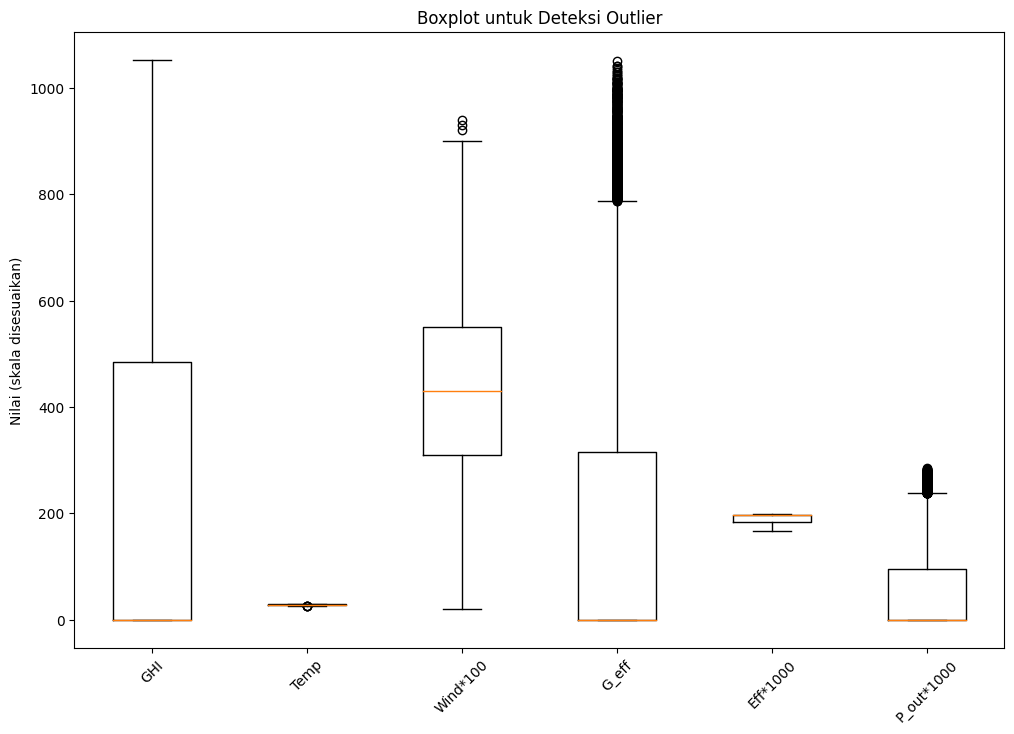

In [74]:
plt.figure(figsize=(12, 8))
plt.boxplot([data['GHI'], data['Temperature'], data['Wind Speed']*100, 
             data['G_eff'], data['efficiency']*1000, data['P_out']*1000],
            labels=['GHI', 'Temp', 'Wind*100', 'G_eff', 'Eff*1000', 'P_out*1000'])
plt.title('Boxplot untuk Deteksi Outlier')
plt.ylabel('Nilai (skala disesuaikan)')
plt.xticks(rotation=45)
plt.show()

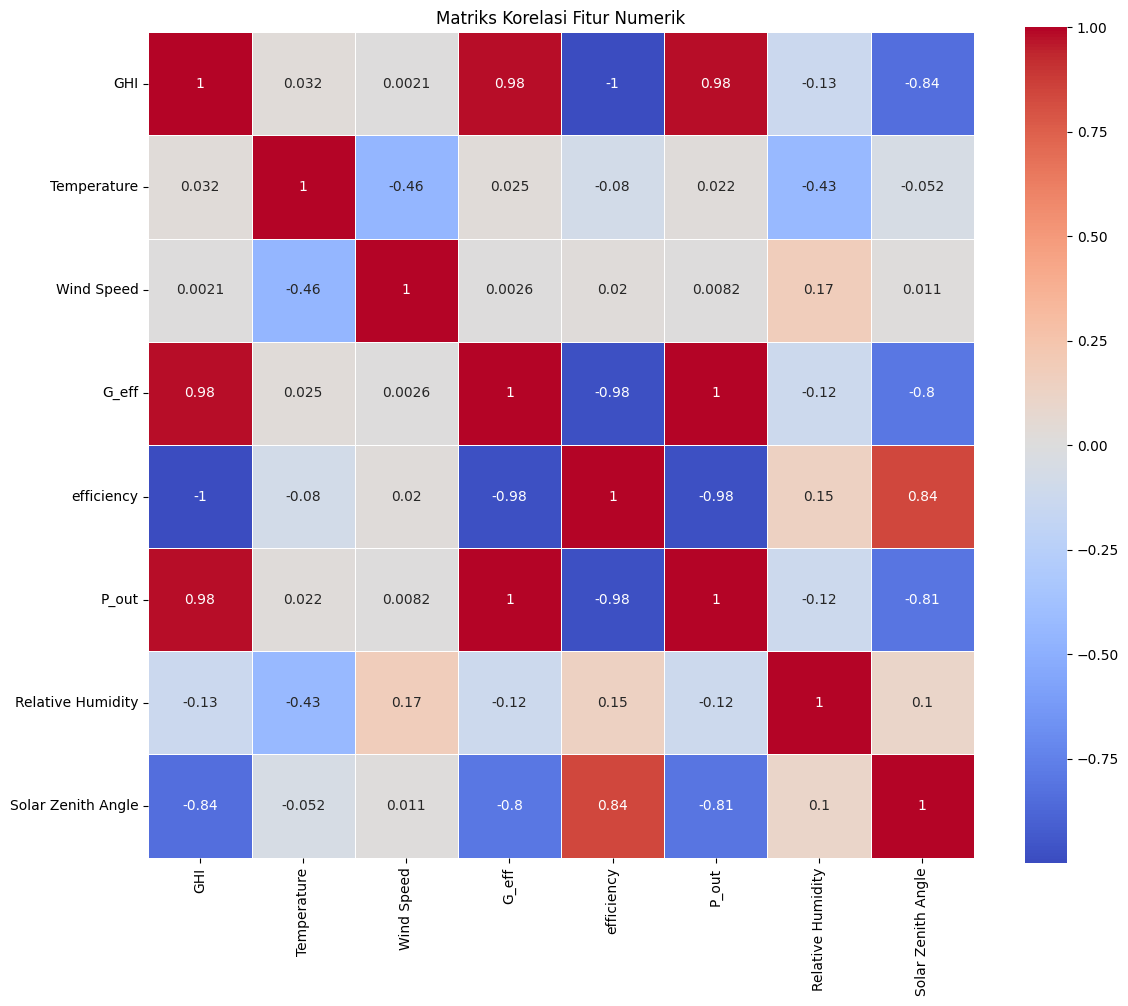

In [75]:
numerical_cols = ['GHI', 'Temperature', 'Wind Speed', 'G_eff', 'efficiency', 
                  'P_out', 'Relative Humidity', 'Solar Zenith Angle']
corr_matrix = data[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matriks Korelasi Fitur Numerik')
plt.tight_layout()
plt.show()


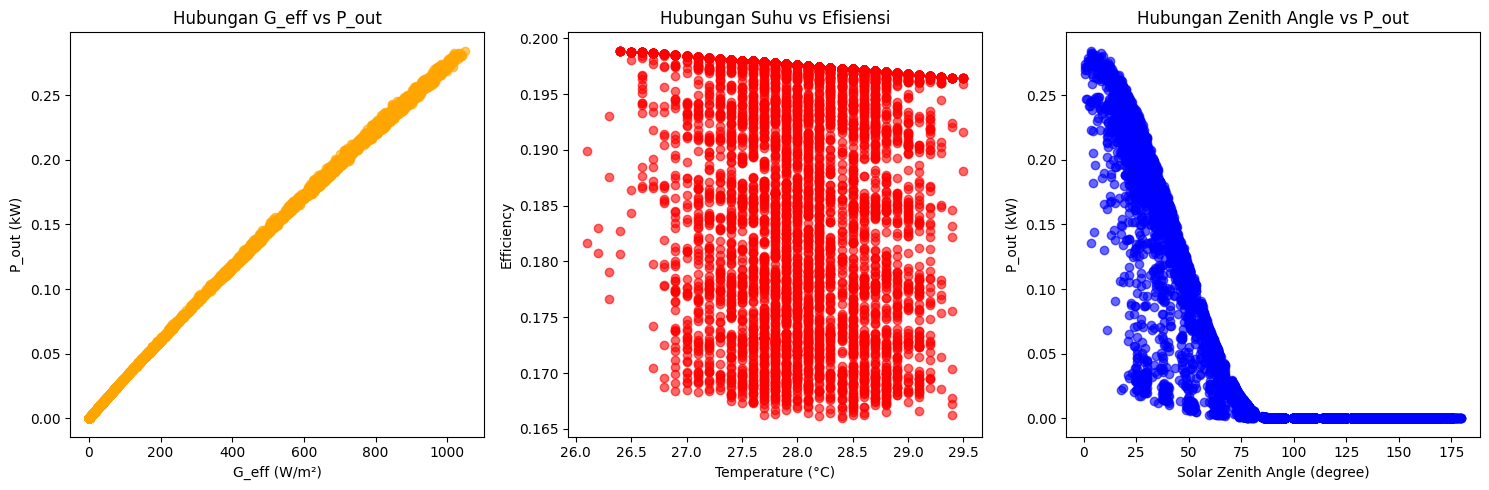

In [76]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(data['G_eff'], data['P_out'], alpha=0.6, color='orange')
plt.xlabel('G_eff (W/m²)')
plt.ylabel('P_out (kW)')
plt.title('Hubungan G_eff vs P_out')

plt.subplot(1, 3, 2)
plt.scatter(data['Temperature'], data['efficiency'], alpha=0.6, color='red')
plt.xlabel('Temperature (°C)')
plt.ylabel('Efficiency')
plt.title('Hubungan Suhu vs Efisiensi')

plt.subplot(1, 3, 3)
plt.scatter(data['Solar Zenith Angle'], data['P_out'], alpha=0.6, color='blue')
plt.xlabel('Solar Zenith Angle (degree)')
plt.ylabel('P_out (kW)')
plt.title('Hubungan Zenith Angle vs P_out')

plt.tight_layout()
plt.show()


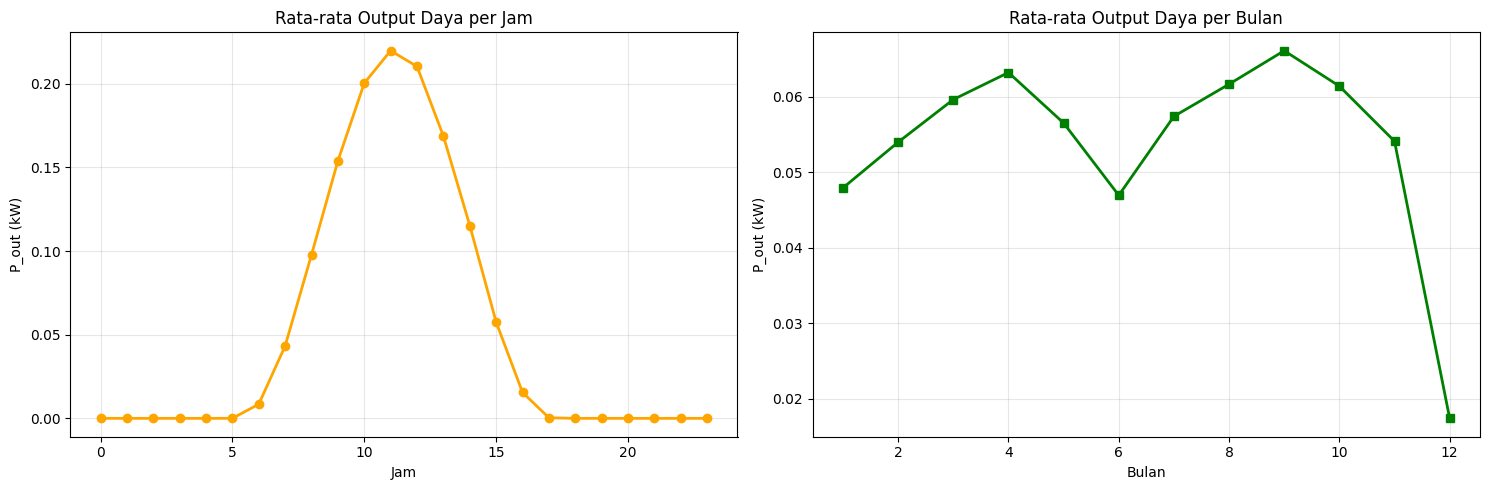

In [77]:
hourly_output = data.groupby('hour')['P_out'].mean()
monthly_output = data.groupby('month')['P_out'].mean()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hourly_output.index, hourly_output.values, marker='o', linewidth=2, color='orange')
plt.title('Rata-rata Output Daya per Jam')
plt.xlabel('Jam')
plt.ylabel('P_out (kW)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(monthly_output.index, monthly_output.values, marker='s', linewidth=2, color='green')
plt.title('Rata-rata Output Daya per Bulan')
plt.xlabel('Bulan')
plt.ylabel('P_out (kW)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [78]:
feature_cols = ['GHI', 'Temperature', 'Wind Speed', 'Relative Humidity', 
                'Solar Zenith Angle', 'G_eff', 'efficiency', 'hour_sin', 
                'hour_cos', 'day_sin', 'day_cos', 'season']

X_temp = data[feature_cols].fillna(0)
y_temp = data['P_out']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_temp, y_temp)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.head()

,feature,importance
5,G_eff,0.999840
2,Wind Speed,0.000076
4,Solar Zenith Angle,0.000029
6,efficiency,0.000019
3,Relative Humidity,0.000008


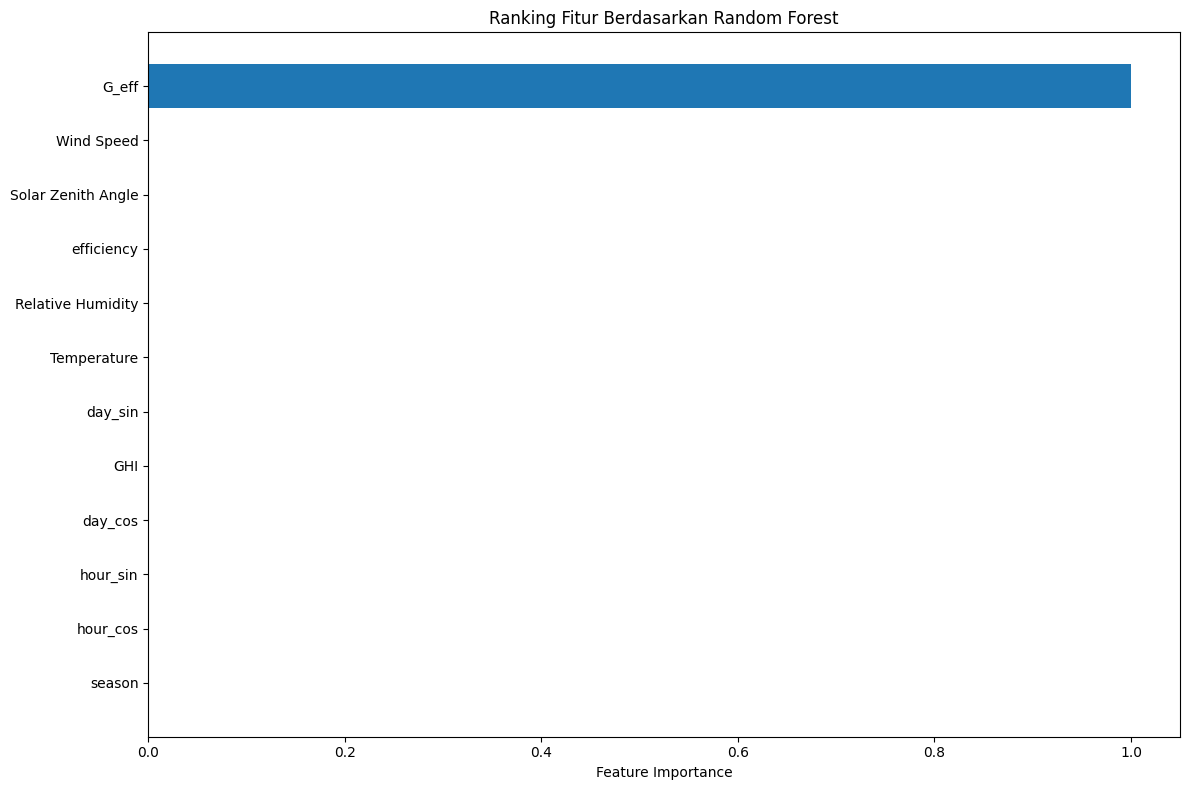

In [79]:
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Ranking Fitur Berdasarkan Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [80]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_temp)
y_scaled = scaler_y.fit_transform(y_temp.values.reshape(-1, 1)).ravel()

X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

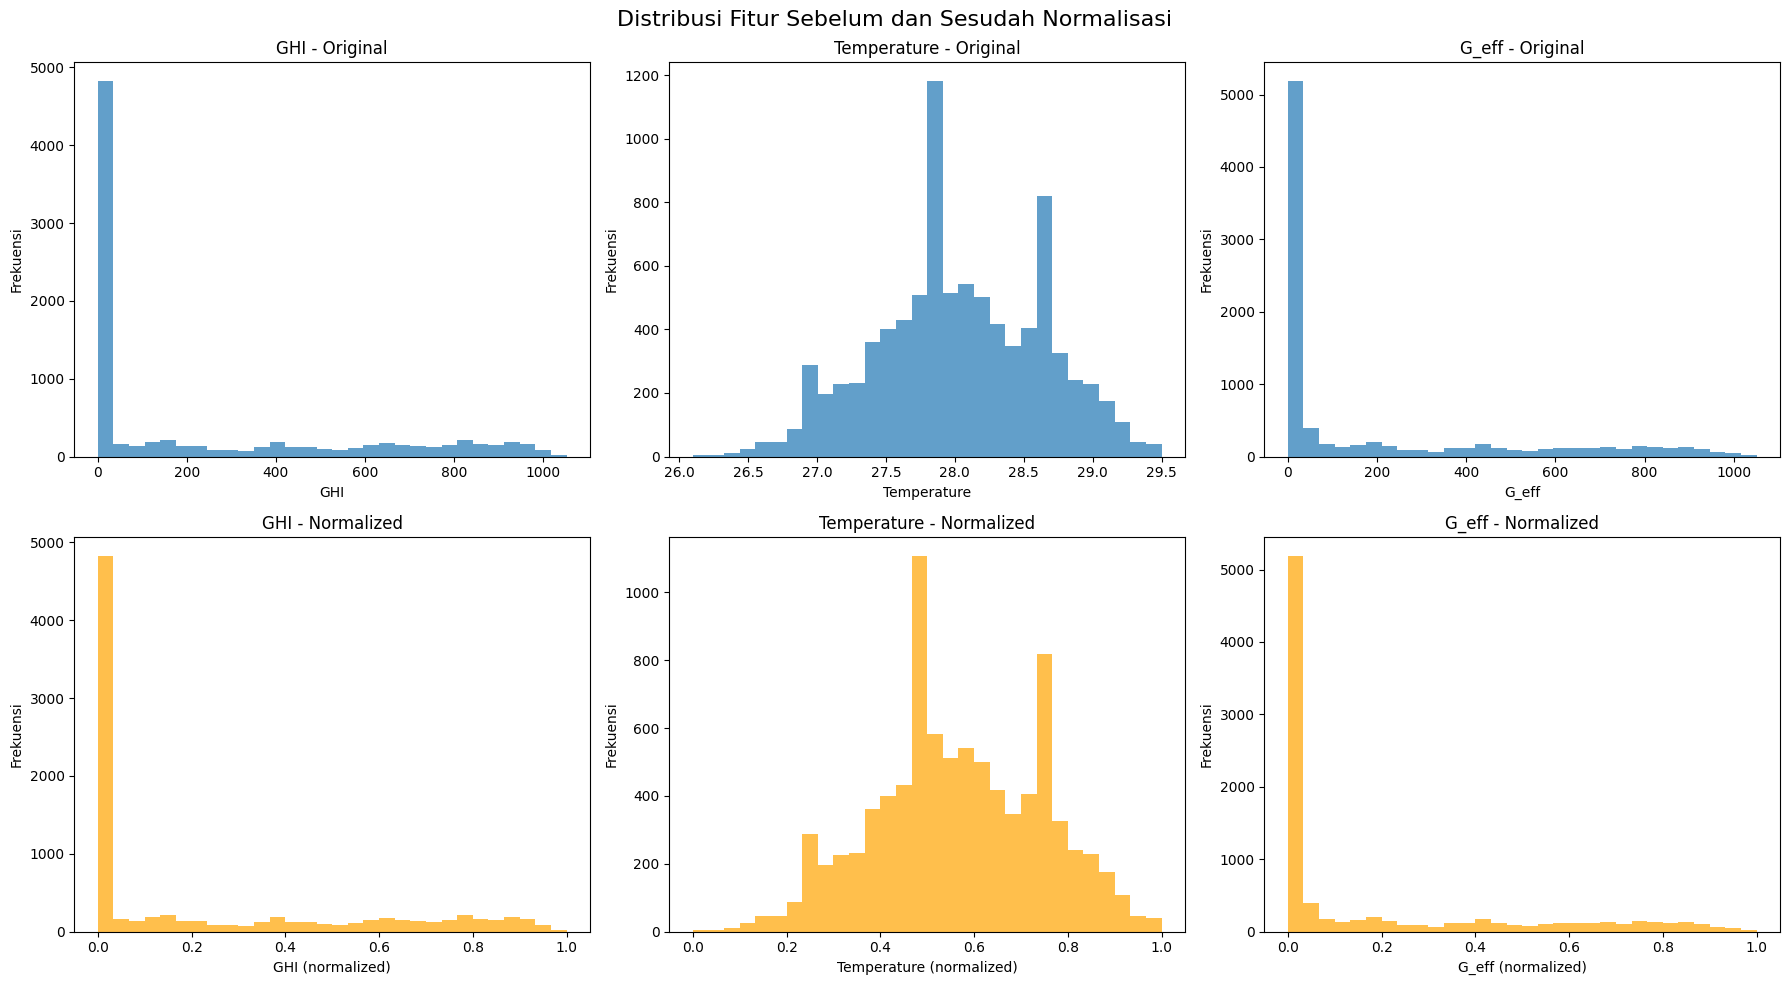

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribusi Fitur Sebelum dan Sesudah Normalisasi', fontsize=16)

sample_cols = ['GHI', 'Temperature', 'G_eff']
for i, col in enumerate(sample_cols):
    plt.subplot(2, 3, i+1)
    plt.hist(X_temp[col], bins=30, alpha=0.7, label='Original')
    plt.title(f'{col} - Original')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    
    plt.subplot(2, 3, i+4)
    plt.hist(X_scaled_df[col], bins=30, alpha=0.7, label='Normalized', color='orange')
    plt.title(f'{col} - Normalized')
    plt.xlabel(f'{col} (normalized)')
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples") 
print(f"Test set: {X_test.shape[0]} samples")


Train set: 5606 samples
Validation set: 1402 samples
Test set: 1752 samples


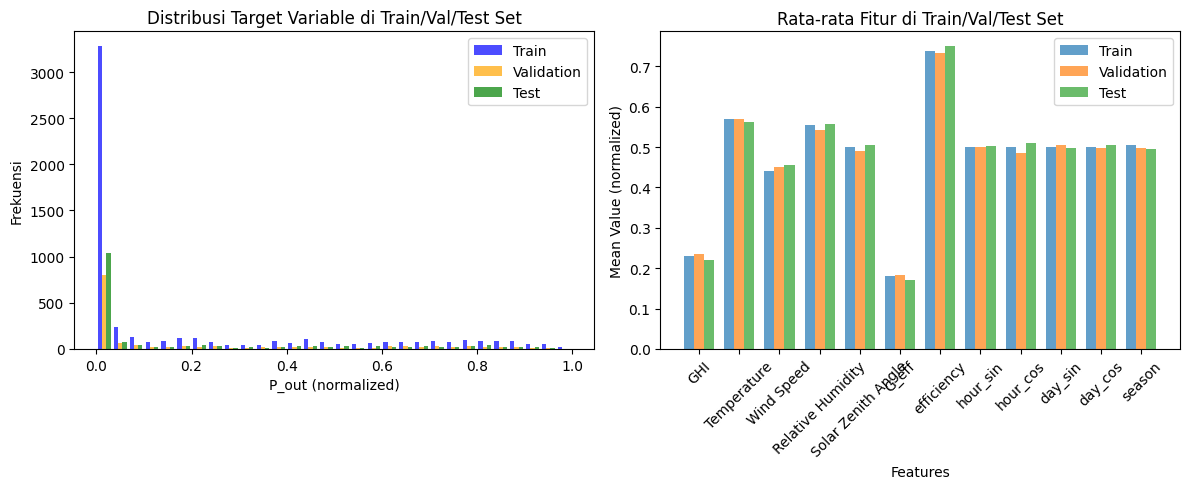

In [83]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist([y_train, y_val, y_test], bins=30, alpha=0.7, 
         label=['Train', 'Validation', 'Test'], color=['blue', 'orange', 'green'])
plt.title('Distribusi Target Variable di Train/Val/Test Set')
plt.xlabel('P_out (normalized)')
plt.ylabel('Frekuensi')
plt.legend()

plt.subplot(1, 2, 2)
train_mean = X_train.mean(axis=0)
val_mean = X_val.mean(axis=0)
test_mean = X_test.mean(axis=0)

x_pos = np.arange(len(feature_cols))
width = 0.25

plt.bar(x_pos - width, train_mean, width, label='Train', alpha=0.7)
plt.bar(x_pos, val_mean, width, label='Validation', alpha=0.7)  
plt.bar(x_pos + width, test_mean, width, label='Test', alpha=0.7)

plt.title('Rata-rata Fitur di Train/Val/Test Set')
plt.xlabel('Features')
plt.ylabel('Mean Value (normalized)')
plt.xticks(x_pos, feature_cols, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
class PINNModel:
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.model = self._build_model()
        
    def _build_model(self):
        inputs = keras.Input(shape=(self.input_dim,))
        
        x = layers.Dense(64, activation='tanh')(inputs)
        x = layers.Dense(64, activation='tanh')(x)
        x = layers.Dense(32, activation='tanh')(x)
        x = layers.Dense(32, activation='tanh')(x)
        x = layers.Dense(16, activation='tanh')(x)
        
        outputs = layers.Dense(1, activation='sigmoid')(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        return model
    
    def physics_loss(self, y_true, y_pred, X_batch):
        ghi = X_batch[:, 0:1] * 1000  
        temp = X_batch[:, 1:2] * 50 + 20  
        zenith = X_batch[:, 4:5] * 90  
        
        g_eff_physics = ghi * tf.cos(zenith * np.pi / 180)
        g_eff_physics = tf.maximum(g_eff_physics, 0.0)
        
        t_cell_physics = temp + (ghi / 800) * 30
        delta_t_physics = t_cell_physics - 25
        eff_physics = 0.2 * (1 - 0.004 * delta_t_physics)
        eff_physics = tf.clip_by_value(eff_physics, 0.05, 0.25)
        
        p_physics = g_eff_physics * 1.65 * eff_physics / 1000
        p_physics_norm = p_physics / tf.reduce_max(p_physics + 1e-8)
        
        physics_residual = tf.reduce_mean(tf.square(y_pred - p_physics_norm))
        
        return physics_residual
    
    def custom_loss(self, lambda_physics=0.1):
        def loss_function(y_true, y_pred):
            mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
            return mse_loss
        return loss_function
    
    def compile_model(self, learning_rate=0.001):
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss=self.custom_loss(),
            metrics=['mae']
        )
        
    def get_callbacks(self):
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7
        )
        
        return [early_stopping, reduce_lr]

pinn = PINNModel(input_dim=X_train.shape[1])
pinn.compile_model(learning_rate=0.001)

pinn.model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,673 (33.88 KB)

 Trainable params: 8,673 (33.88 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
callbacks = pinn.get_callbacks()

history = pinn.model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0306 - mae: 0.1174 - val_loss: 0.0010 - val_mae: 0.0288 - learning_rate: 0.0010
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8404e-04 - mae: 0.0261 - val_loss: 5.0404e-04 - val_mae: 0.0190 - learning_rate: 0.0010
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5127e-04 - mae: 0.0180 - val_loss: 2.7530e-04 - val_mae: 0.0137 - learning_rate: 0.0010
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6274e-04 - mae: 0.0133 - val_loss: 2.9444e-04 - val_mae: 0.0139 - learning_rate: 0.0010
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9163e-04 - mae: 0.0111 - val_loss: 1.8431e-04 - val_mae: 0.0109 - learning_rate: 0.0010
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6297e-04 - mae: 0.0102 - val_loss: 1.2097e-04 - val_mae: 0.0088 - learning_rate: 0.0010
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3786e-04 - mae: 0.0093 - val_loss: 9.95

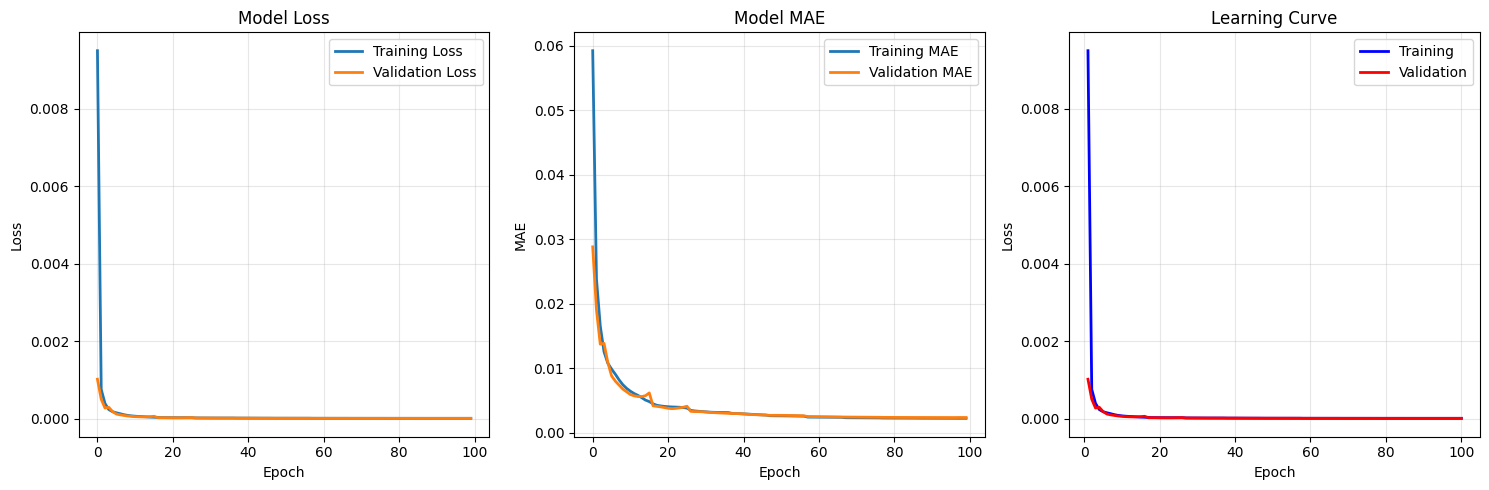

In [86]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'b-', label='Training', linewidth=2)
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation', linewidth=2)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [87]:
y_train_pred = pinn.model.predict(X_train).ravel()
y_val_pred = pinn.model.predict(X_val).ravel()
y_test_pred = pinn.model.predict(X_test).ravel()

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

train_mae, train_rmse, train_r2 = calculate_metrics(y_train, y_train_pred)
val_mae, val_rmse, val_r2 = calculate_metrics(y_val, y_val_pred)
test_mae, test_rmse, test_r2 = calculate_metrics(y_test, y_test_pred)

print(f"Train - MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
print(f"Val   - MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
print(f"Test  - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train - MAE: 0.0023, RMSE: 0.0030, R²: 0.9999
Val   - MAE: 0.0024, RMSE: 0.0030, R²: 0.9999
Test  - MAE: 0.0023, RMSE: 0.0031, R²: 0.9999


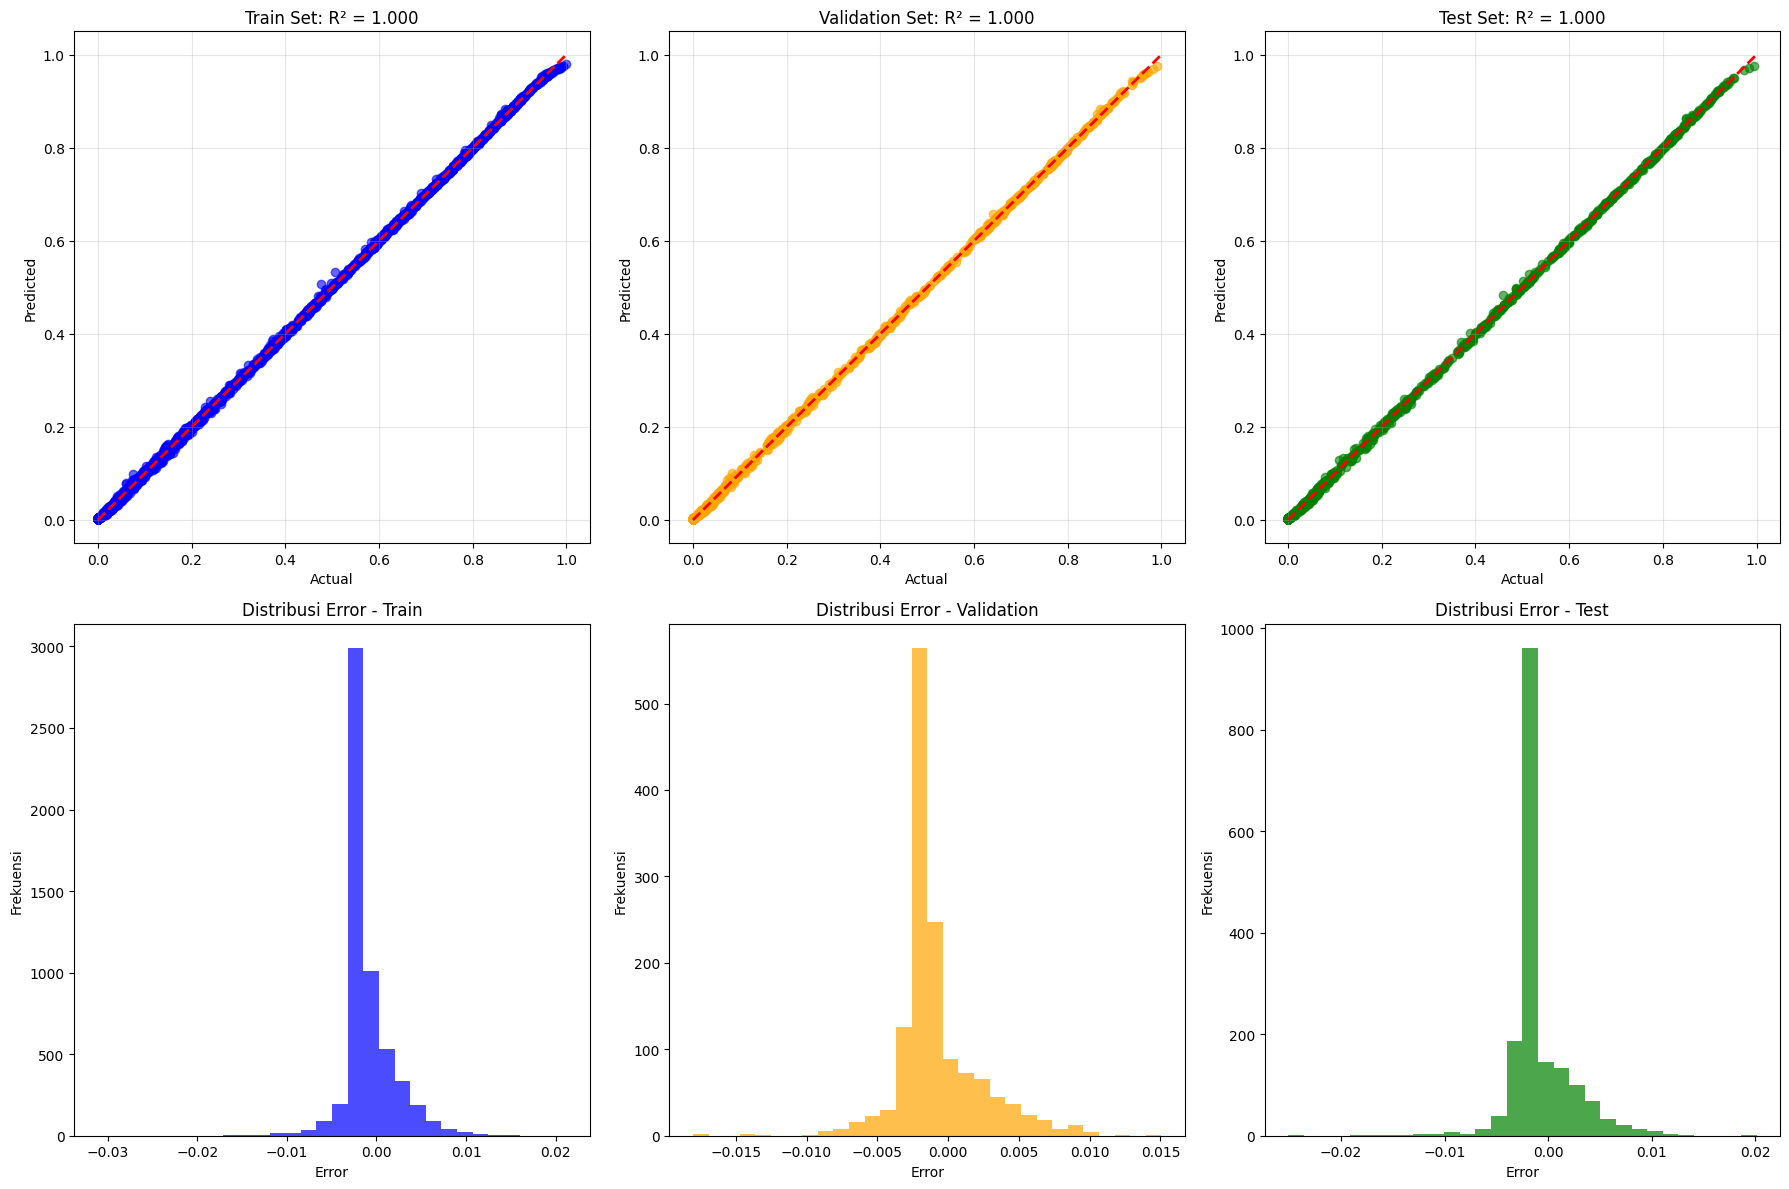

In [88]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Train Set: R² = {train_r2:.3f}')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.scatter(y_val, y_val_pred, alpha=0.6, color='orange')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Validation Set: R² = {val_r2:.3f}')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test Set: R² = {test_r2:.3f}')
plt.grid(True, alpha=0.3)

residuals_train = y_train - y_train_pred
residuals_val = y_val - y_val_pred
residuals_test = y_test - y_test_pred

plt.subplot(2, 3, 4)
plt.hist(residuals_train, bins=30, alpha=0.7, color='blue')
plt.title('Distribusi Error - Train')
plt.xlabel('Error')
plt.ylabel('Frekuensi')

plt.subplot(2, 3, 5)
plt.hist(residuals_val, bins=30, alpha=0.7, color='orange')
plt.title('Distribusi Error - Validation')
plt.xlabel('Error')
plt.ylabel('Frekuensi')

plt.subplot(2, 3, 6)
plt.hist(residuals_test, bins=30, alpha=0.7, color='green')
plt.title('Distribusi Error - Test')
plt.xlabel('Error')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()


In [89]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

lr_test_pred = lr_model.predict(X_test)
rf_test_pred = rf_model.predict(X_test)

lr_mae, lr_rmse, lr_r2 = calculate_metrics(y_test, lr_test_pred)
rf_mae, rf_rmse, rf_r2 = calculate_metrics(y_test, rf_test_pred)

comparison_data = {
    'Model': ['PINN', 'Linear Regression', 'Random Forest'],
    'MAE': [test_mae, lr_mae, rf_mae],
    'RMSE': [test_rmse, lr_rmse, rf_rmse],
    'R²': [test_r2, lr_r2, rf_r2]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.head()

,Model,MAE,RMSE,R²
0,PINN,0.002347,0.003114,0.999878
1,Linear Regression,0.004239,0.006396,0.999486
2,Random Forest,0.000978,0.002181,0.999940


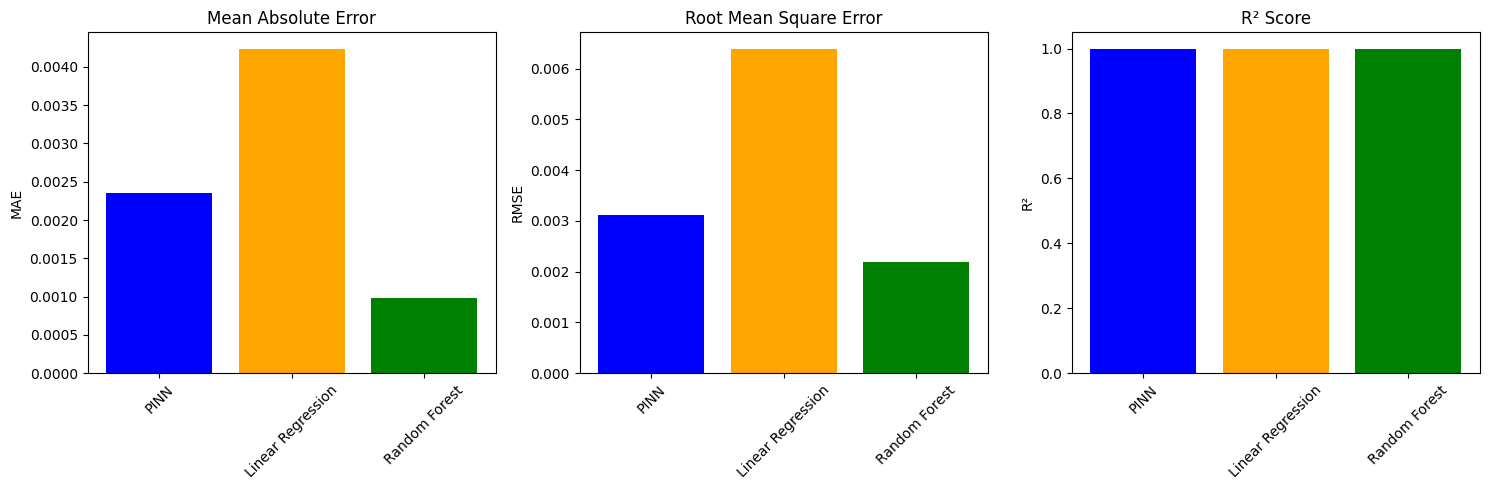

In [90]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(comparison_df['Model'], comparison_df['MAE'], color=['blue', 'orange', 'green'])
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color=['blue', 'orange', 'green'])
plt.title('Root Mean Square Error')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(comparison_df['Model'], comparison_df['R²'], color=['blue', 'orange', 'green'])
plt.title('R² Score')
plt.ylabel('R²')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

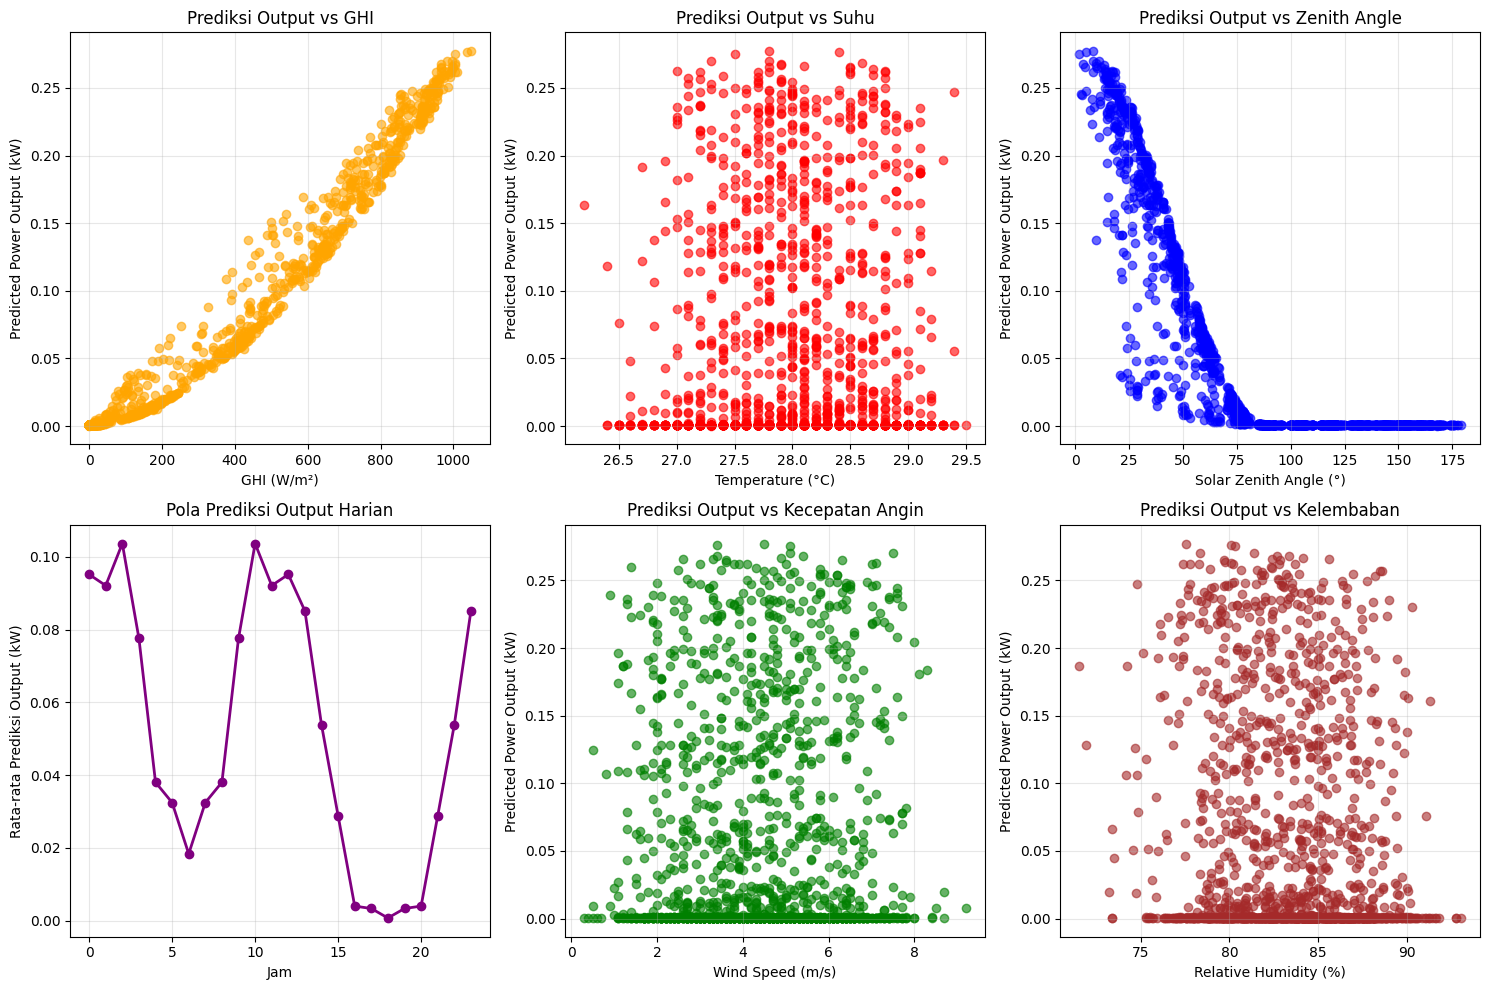

In [91]:
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_test_pred_original = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()

X_test_original = scaler_X.inverse_transform(X_test)
X_test_df = pd.DataFrame(X_test_original, columns=feature_cols)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter(X_test_df['GHI'], y_test_pred_original, alpha=0.6, color='orange')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('Prediksi Output vs GHI')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.scatter(X_test_df['Temperature'], y_test_pred_original, alpha=0.6, color='red')
plt.xlabel('Temperature (°C)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('Prediksi Output vs Suhu')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.scatter(X_test_df['Solar Zenith Angle'], y_test_pred_original, alpha=0.6, color='blue')
plt.xlabel('Solar Zenith Angle (°)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('Prediksi Output vs Zenith Angle')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
hourly_pred = []
for hour in range(24):
    hour_mask = X_test_df['hour_sin'].apply(lambda x: abs(x - np.sin(2*np.pi*hour/24)) < 0.1)
    if hour_mask.sum() > 0:
        hourly_pred.append(y_test_pred_original[hour_mask].mean())
    else:
        hourly_pred.append(0)

plt.plot(range(24), hourly_pred, marker='o', linewidth=2, color='purple')
plt.xlabel('Jam')
plt.ylabel('Rata-rata Prediksi Output (kW)')
plt.title('Pola Prediksi Output Harian')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.scatter(X_test_df['Wind Speed'], y_test_pred_original, alpha=0.6, color='green')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('Prediksi Output vs Kecepatan Angin')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.scatter(X_test_df['Relative Humidity'], y_test_pred_original, alpha=0.6, color='brown')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('Prediksi Output vs Kelembaban')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [92]:
high_performance_mask = y_test_pred_original > np.percentile(y_test_pred_original, 75)
low_performance_mask = y_test_pred_original < np.percentile(y_test_pred_original, 25)

print("Kondisi untuk performa tinggi (Q3):")
print(f"GHI rata-rata: {X_test_df[high_performance_mask]['GHI'].mean():.1f} W/m²")
print(f"Suhu rata-rata: {X_test_df[high_performance_mask]['Temperature'].mean():.1f} °C")
print(f"Zenith angle rata-rata: {X_test_df[high_performance_mask]['Solar Zenith Angle'].mean():.1f}°")
print(f"Kecepatan angin rata-rata: {X_test_df[high_performance_mask]['Wind Speed'].mean():.1f} m/s")

print("\nKondisi untuk performa rendah (Q1):")
print(f"GHI rata-rata: {X_test_df[low_performance_mask]['GHI'].mean():.1f} W/m²")
print(f"Suhu rata-rata: {X_test_df[low_performance_mask]['Temperature'].mean():.1f} °C")
print(f"Zenith angle rata-rata: {X_test_df[low_performance_mask]['Solar Zenith Angle'].mean():.1f}°")
print(f"Kecepatan angin rata-rata: {X_test_df[low_performance_mask]['Wind Speed'].mean():.1f} m/s")

ghi_ranges = pd.cut(X_test_df['GHI'], bins=5, labels=['Sangat Rendah', 'Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi'])
performance_by_ghi = pd.DataFrame({
    'GHI_Range': ghi_ranges,
    'Power_Output': y_test_pred_original
}).groupby('GHI_Range')['Power_Output'].mean()

Kondisi untuk performa tinggi (Q3):
GHI rata-rata: 744.7 W/m²
Suhu rata-rata: 28.0 °C
Zenith angle rata-rata: 31.4°
Kecepatan angin rata-rata: 4.4 m/s

Kondisi untuk performa rendah (Q1):
GHI rata-rata: 0.0 W/m²
Suhu rata-rata: 28.0 °C
Zenith angle rata-rata: 151.7°
Kecepatan angin rata-rata: 4.4 m/s


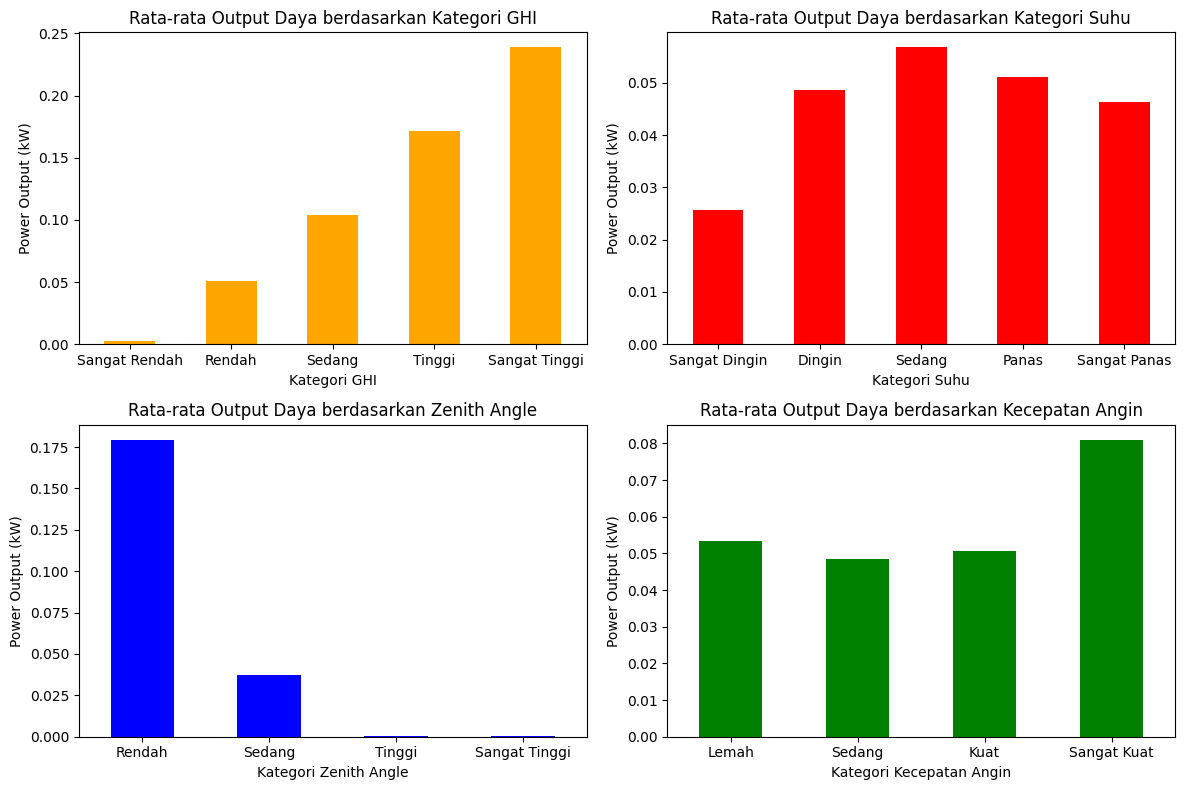

In [93]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
performance_by_ghi.plot(kind='bar', color='orange')
plt.title('Rata-rata Output Daya berdasarkan Kategori GHI')
plt.xlabel('Kategori GHI')
plt.ylabel('Power Output (kW)')
plt.xticks(rotation=0)

temp_ranges = pd.cut(X_test_df['Temperature'], bins=5, labels=['Sangat Dingin', 'Dingin', 'Sedang', 'Panas', 'Sangat Panas'])
performance_by_temp = pd.DataFrame({
    'Temp_Range': temp_ranges,
    'Power_Output': y_test_pred_original
}).groupby('Temp_Range')['Power_Output'].mean()

plt.subplot(2, 2, 2)
performance_by_temp.plot(kind='bar', color='red')
plt.title('Rata-rata Output Daya berdasarkan Kategori Suhu')
plt.xlabel('Kategori Suhu')
plt.ylabel('Power Output (kW)')
plt.xticks(rotation=0)

zenith_ranges = pd.cut(X_test_df['Solar Zenith Angle'], bins=4, labels=['Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi'])
performance_by_zenith = pd.DataFrame({
    'Zenith_Range': zenith_ranges,
    'Power_Output': y_test_pred_original
}).groupby('Zenith_Range')['Power_Output'].mean()

plt.subplot(2, 2, 3)
performance_by_zenith.plot(kind='bar', color='blue')
plt.title('Rata-rata Output Daya berdasarkan Zenith Angle')
plt.xlabel('Kategori Zenith Angle')
plt.ylabel('Power Output (kW)')
plt.xticks(rotation=0)

wind_ranges = pd.cut(X_test_df['Wind Speed'], bins=4, labels=['Lemah', 'Sedang', 'Kuat', 'Sangat Kuat'])
performance_by_wind = pd.DataFrame({
    'Wind_Range': wind_ranges,
    'Power_Output': y_test_pred_original
}).groupby('Wind_Range')['Power_Output'].mean()

plt.subplot(2, 2, 4)
performance_by_wind.plot(kind='bar', color='green')
plt.title('Rata-rata Output Daya berdasarkan Kecepatan Angin')
plt.xlabel('Kategori Kecepatan Angin')
plt.ylabel('Power Output (kW)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [94]:
def simulate_scenario(ghi_factor=1.0, temp_offset=0, wind_factor=1.0, scenario_name="Base"):
    X_scenario = X_test.copy()
    X_scenario[:, 0] *= ghi_factor  # GHI
    X_scenario[:, 1] = (X_scenario[:, 1] * 50 + 20 + temp_offset - 20) / 50  # Temperature
    X_scenario[:, 2] *= wind_factor  # Wind Speed
    
    X_scenario = np.clip(X_scenario, 0, 1)
    
    y_scenario_pred = pinn.model.predict(X_scenario).ravel()
    y_scenario_original = scaler_y.inverse_transform(y_scenario_pred.reshape(-1, 1)).ravel()
    
    return y_scenario_original.mean()

scenarios = {
    'Normal': simulate_scenario(1.0, 0, 1.0, 'Normal'),
    'Musim Kemarau (+20% GHI, +3°C)': simulate_scenario(1.2, 3, 1.0, 'Musim Kemarau'),
    'Musim Hujan (-30% GHI, -2°C)': simulate_scenario(0.7, -2, 1.0, 'Musim Hujan'), 
    'Angin Kencang (+50% Wind)': simulate_scenario(1.0, 0, 1.5, 'Angin Kencang'),
    'Kondisi Optimal (+15% GHI, -1°C, +20% Wind)': simulate_scenario(1.15, -1, 1.2, 'Optimal'),
    'Kondisi Ekstrem (-40% GHI, +5°C)': simulate_scenario(0.6, 5, 1.0, 'Ekstrem')
}

scenario_df = pd.DataFrame(list(scenarios.items()), columns=['Skenario', 'Rata_rata_Output_kW'])
scenario_df['Perubahan_Persen'] = ((scenario_df['Rata_rata_Output_kW'] - scenarios['Normal']) / scenarios['Normal'] * 100).round(1)

print("\nHASIL SIMULASI SKENARIO:")
print(scenario_df.to_string(index=False))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

HASIL SIMULASI SKENARIO:
                                   Skenario  Rata_rata_Output_kW  Perubahan_Persen
                                     Normal             0.051605               0.0
             Musim Kemarau (+20% GHI, +3°C)             0.051267              -0.7
               Musim Hujan (-30% GHI, -2°C)             0.051991               0.7
                  Angin Kencang (+50% Wind)             0.052151               1.1
Kondisi Optimal (+15% GHI, -1°C, +20% Wind)             0.051812               0.4
           Kondisi Ekstrem (-40% GHI, +5°C)             0.051421              -0.4


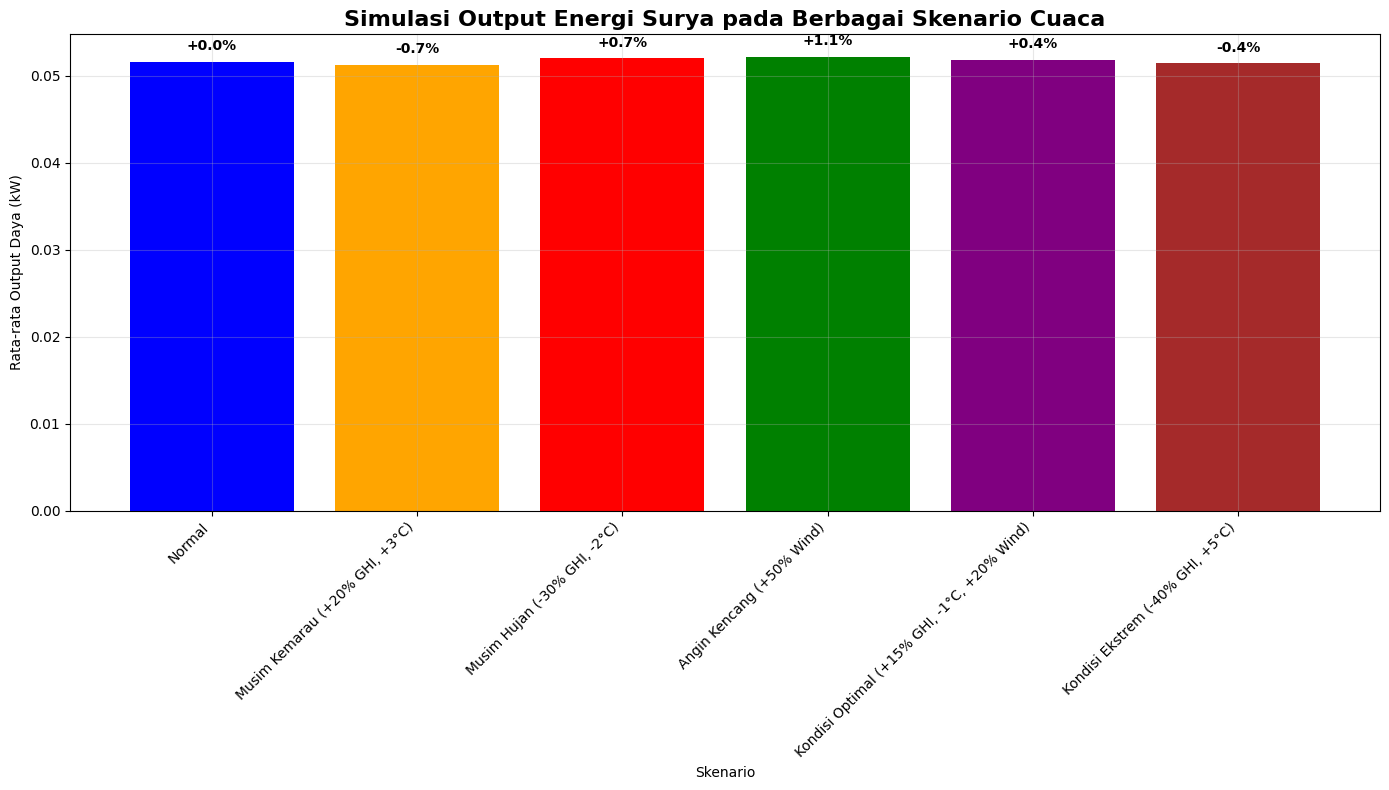

In [95]:
plt.figure(figsize=(14, 8))
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown']
bars = plt.bar(range(len(scenario_df)), scenario_df['Rata_rata_Output_kW'], color=colors)

for i, (bar, change) in enumerate(zip(bars, scenario_df['Perubahan_Persen'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{change:+.1f}%', ha='center', va='bottom', fontweight='bold')

plt.title('Simulasi Output Energi Surya pada Berbagai Skenario Cuaca', fontsize=16, fontweight='bold')
plt.xlabel('Skenario')
plt.ylabel('Rata-rata Output Daya (kW)')
plt.xticks(range(len(scenario_df)), scenario_df['Skenario'], rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()